### <center>Python for finance II: Reddit stock market prediction

<center> University of Vienna
    
Credits: Bernd Prostmaier

## Stock market prediction (early signal model) for most trending S&P 500 stocks on Reddit

This project work deals with scraping the Reddit API in order to get information about the most discussed S&P 500 stocks as well as creating an early signal model for the top 3 most discussed stocks.

In order to get information about the structure, data and methodology of this project please have a look at the corresponding project report (**PFF2_Project_Report.pdf**)! Anyway, the most fundamental things are described below.

This project is divided into two separate classes. Each class stands individually and can be used for separate analysis if needed. Class description:

- **RedditData:** Scraps data from the Reddit 'praw' library. Provides information about the most discussed S&P 500 stocks and their corresponding sentiment.
- **RedditPredict:** Scraps stock market data from the 'yfinance' library for the most trending stocks out of the RedditData class. Predicts the stock market development within the next 5 days based on a random forest algorithm and creates an early signal model.


In addition to some standard libraries (e.g. numpy, pandas, sklearn, etc.), the research used the following more specialized libraries:<br>
- __[praw:](https://praw.readthedocs.io/en/stable/)__ Scraping Reddit API<br>
- __[Vader Sentiment Analyzer:](https://github.com/cjhutto/vaderSentiment)__ Sentiment analysis<br>
- __[yfinance:](https://pypi.org/project/yfinance/)__ Scraping stock market data<br>
- __[TA-Lib:](https://github.com/mrjbq7/ta-lib)__ Performing technical analysis





### Loading required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import praw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import squarify as sq
import matplotlib
import regex as re
import math
from datetime import date
import pandas_datareader as web
import yfinance as yf
import talib as ta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from datetime import date
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


### Reddit user data
#from keys import ID, Secret, Agent, Uname, RedditPW

### 1. RedditData: Scraping data from Reddit

In [2]:
class RedditData:

    def __init__(self, name1, name2, name3, name4, n = 10):
        # Reddit API Setup
        self.reddit = praw.Reddit(client_id="WGAn64G4vFVNhw",
                                  client_secret="VkTA3OresfoRxmg4-hXQxO7UKxR2xQ",
                                  user_agent="bboy",
                                  username="Matrixhamster1",
                                  password="Leo-Hund123")

        ### Loading desired subreddits
        sr1 = self.reddit.subreddit(name1)
        sr2 = self.reddit.subreddit(name2)
        sr3 = self.reddit.subreddit(name3)
        sr4 = self.reddit.subreddit(name4)

        ### Choosing hot submissions
        sr1_hot = sr1.hot(limit = n)
        sr2_hot = sr2.hot(limit = n)
        sr3_hot = sr3.hot(limit = n)
        sr4_hot = sr4.hot(limit = n)

        ### Moving all together
        self.totalsubreds = [sr1_hot, sr2_hot, sr3_hot, sr4_hot]
        print(f"Loaded {n*4} submissions from {len(self.totalsubreds)} subreddits.")


    def DataProcessing(self, n = 10, commentdepth = 2 ,visual = True):

        ### S&P 500 ticker
        scrab = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        sp500_ticker = pd.read_html(scrab)
        sp500_ticker = sp500_ticker[0]
        ticker = sp500_ticker["Symbol"].values.tolist()

        ## Creating ticker dictionary
        ticker_dic = {}
        for i in ticker:
            ticker_dic[i] = 0

        ### Dicts & lists for later use
        hot_ticks = {}
        self.all_comments = {}      # Stores all comments which relates to a S&P 500 stock
        count = 0
        self.top_10 = {}            # Stores top n mentioned stocks
        counter2 = []               # Needed for plots
        self.n = n
        comment_counter = 0         # Total amount of comments scraped


        ### Iterating through subreddits
        for subreddit in self.totalsubreds:

            ## Iterating through submissions in subreddits
            for submission in subreddit:

                # Preparing comment section
                submission.comment_sort = "new"
                comments = submission.comments
                submission.comments.replace_more(limit = commentdepth)
                comment_counter += len(comments)

                ## Loop through comments
                for comment in comments:
                    splitted_comments = comment.body.split(" ")

                    # Loop through every word within each comment
                    for word in splitted_comments:

                        # Searching for stock ticker
                        if word.isupper() and len(word) <=5 and word in ticker:

                            if word not in hot_ticks:                       # Initialize ticker counter
                                hot_ticks[word] = 1
                                self.all_comments[word] = [comment.body]    # Storing the tickers comment
                                count += 1
                            else:                                           # Overwrite/Edit ticker counter
                                hot_ticks[word] += 1
                                self.all_comments[word].append(comment.body)
                                count += 1


        ### Sorting Results
        # Ordering stocks according to their appearance
        self.all_matches = dict(sorted(hot_ticks.items(), key=lambda item: item[1], reverse=True))
        # Shows only top 10 mentioned stocks (without count)
        self.top_picks = list(self.all_matches.keys())[0:self.n]

        ### Creating top_n mentioned S&P 500 ticker list
        for i in self.top_picks:
            self.top_10[i] = self.all_matches[i]
            counter2.append(f"{i}: {self.all_matches[i]}")

        ### Output
        print(f"Searched within {comment_counter} comments for S&P 500 ticker.\n")
        
        print(f"Top {self.n} most mentioned picks: ")
        for k,v in self.top_10.items():
            print(f"{k}: {v}")
        
        counter1 = list(self.top_10.values())  # Counting top 10 appearance, needed plot
        counter2 = counter2                    # Plot label

        ### Vizualisation of results
        if visual == True:
            plt.figure(figsize = (12, 8))
            sq.plot(sizes = counter1,
                    label = counter2,
                    alpha = .7,
                    color = ["darkgreen", "forestgreen", "mediumseagreen", "dimgrey",
                           "grey", "darkgrey", "silver", "lightgrey", "gainsboro", "whitesmoke"],
                    text_kwargs = {"fontsize": 16})
            plt.axis("off")
            plt.title(f"{self.n} most mentioned stocks on Reddit as of {str(date.today())} \n", fontsize = 23)
            plt.show()


    def Sentiment(self, threshold = 0.5):

        """ Using vader sentiment library (see: https://github.com/cjhutto/vaderSentiment)
        The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to
        the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is
        the most useful metric if you want a single unidimensional measure of sentiment for a given sentence.
        Calling it a 'normalized, weighted composite score' is accurate.

        It is also useful for researchers who would like to set standardized thresholds for classifying sentences as
        either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

            positive sentiment: compound score >= 0.05
            neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
            negative sentiment: compound score <= -0.05
        NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers,  
        including the authors. 
        
        (quoted from https://github.com/cjhutto/vaderSentiment) 
        """

        ### Extending the sentiment library with typical reddit language in order
        ### to receive better results
        new_words = {
            # positive
            "moon": 4.0, "mooning": 4.0, "call": 4.0, "buy":4.0, "crack": 3.5, "undervalued": 3.0,
            "bullish": 3.0, "upgrade": 3.0, "rocket": 2.5, "Stonk": 2.5, "tendie": 2.5, "highs": 2.0, 
            "long": 2.0, "green": 1.5, 
            
            # negative
            "hindenburg": -4.0, "sell": -4.0, "put": -4.0, "gtfo": -4.0, "bearish": -3.0, "short": -3.0,
            "bear": -3.0, "drop": -3.0, "offering": -2.5 , "pumping": -1.5, "bagholder": -1.5}

        ### Dicts for saving the sentiment scores
        ratings = dict() # sentiment score
        sc = dict()

        ### Report output
        # Df saving the comments for later report purposes
        self.reportdf = pd.DataFrame(columns=("Stock", "Sentiment", "Comment")) 
        run = 0          # Running variable

        ### Setup sentiment library
        vader = SentimentIntensityAnalyzer()
        vader.lexicon.update(new_words)

        ### Scoring only top 10 ticker comments!
        for symbol in self.top_picks:
            indv_stock = self.all_comments[symbol]   # List with all comments for each ticker

            ## Loop through every comment within the list of comments of a particular stock
            for comm in indv_stock:

                ## Preprocessing for better sentiment results
                comm = comm.lower()
                comm = re.sub("\n", " ", comm)
                comm = re.sub("\r", " ", comm)

                ## Compute Sentiment score for each comment
                score = vader.polarity_scores(comm)

                ## Saving score + comment within dictionary
                if symbol not in sc:                 # Create ticker + score value (incl comment)
                    sc[symbol] = {comm: score}
                else:                                # Update dictionary
                    sc[symbol][comm] = score

                ## Saving only the sentiment scores
                if symbol not in ratings:            # Create ticker + score value (only rating)
                    ratings[symbol] = score

                else:                                # Update values (aggregating scores)
                    for item, _ in score.items():
                        ratings[symbol][item] += score[item]

                        
                ## Saving overall sentiment score (compound) for later report (see project report)
                if score["compound"] < -threshold:
                    overallsentiment = "negative"
                if score["compound"] <= threshold and score["compound"] >= -threshold:
                    overallsentiment = "neutral"
                else:
                    overallsentiment = "positive"
                # Add overall sentiment to reportdf
                self.reportdf.loc[run] = [symbol, overallsentiment, comm]
                run += 1


            ## Averaging: Iterating through aggregated sentiment scores, in order to compute the average
            ## sentiment score for each stock
            for item in score:
                ratings[symbol][item] = ratings[symbol][item] / self.all_matches[symbol]  # Averaging
                ratings[symbol][item] = "{:.3f}".format(ratings[symbol][item])            # Display 3 decimals

                
        ## Output of sentiment analysis
        senti_df = pd.DataFrame(ratings)
        senti_df.index = ['Negative', 'Neutral', 'Positive', 'Compound']
        senti_df = senti_df.transpose()
        print(f"\nSentiment analysis of top {self.n} picks:")
        print(senti_df)
        self.sentiment_df = senti_df


    def Dataviz_Sentiment(self):

        ### Vizualise the sentiment_df
        plt.figure(figsize=(16, 12))
        colors = ["seagreen", "silver", "firebrick"]
        plotdf = self.sentiment_df.astype(float).drop(columns="Compound")
        
        # Axis
        ax = plotdf.plot.bar(stacked=True, color=colors, width = 0.55)
        ax.set_facecolor('whitesmoke')
        plt.grid(color='w', linestyle='solid')
        ax.set_axisbelow(True)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        
        # Plot
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol = 3)
        plt.title(f"Sentiment of the {self.n} most mentioned stocks on reddit\n", fontsize = 14)
        plt.ylabel("Sentiment score", fontsize = 13)
        plt.xticks(rotation=30, horizontalalignment="center", fontsize = 10)
        plt.tight_layout()
        plt.show()
        plt.style.use("default")


### See the results:

**1. Step:** Initialize the RedditData class. Define the required subreddits and the number of submissions to be scraped for each subreddit as arguments.

In [3]:
rd = RedditData("wallstreetbets", "StockMarket", "Stocks", "investing", n = 1000)

Loaded 4000 submissions from 4 subreddits.


**2. Step:** Processing the data. Define on how many levels the comments should be scanned. Additionally, define how many of the most counted shares should be displayed and whether the results should be visualized or not.

Searched within 36060 comments for S&P 500 ticker.

Top 10 most mentioned picks: 
A: 496
NVDA: 300
AMD: 206
DD: 170
AAPL: 160
TSLA: 145
MRNA: 108
MSFT: 106
AMZN: 88
NFLX: 64


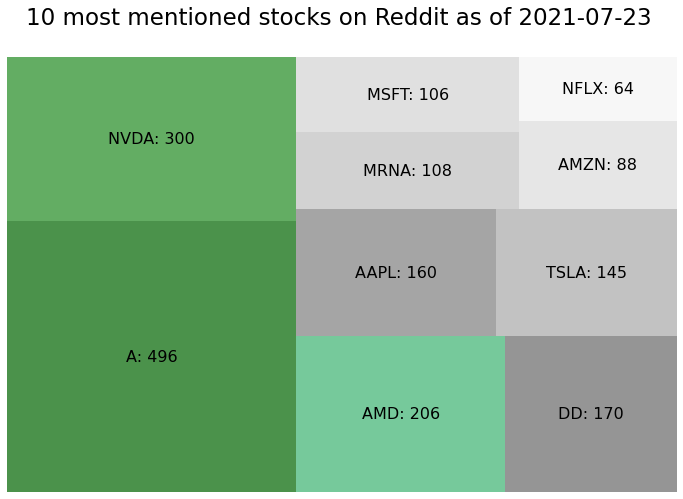

In [4]:
rd.DataProcessing(commentdepth = 30, n = 10, visual = True)

**3. Step:** Performing sentiment analysis using the 'vader sentiment analyzer'. One can specify the threshold for categorizing each comment into one of the sentiment categories: positive, negative or neutral, using vader's compound score (see project report).

- Positive:  $compound > threshold$
- Negative:  $compound < -threshold$
- Neutral:   $-threshold \leq compound \leq threshold$

At this time, the objects instance provides different outputs. The most important ones are the sentiment scores as well as the categorization of each comment into one sentiment category.

In [5]:
rd.Sentiment(threshold = 0.5)


Sentiment analysis of top 10 picks:
     Negative Neutral Positive Compound
A       0.093   0.772    0.129    0.163
NVDA    0.065   0.805    0.131    0.190
AMD     0.052   0.814    0.134    0.204
DD      0.070   0.808    0.123    0.198
AAPL    0.060   0.828    0.112    0.149
TSLA    0.076   0.808    0.116    0.144
MRNA    0.111   0.768    0.121    0.032
MSFT    0.059   0.846    0.095    0.208
AMZN    0.067   0.802    0.130    0.197
NFLX    0.075   0.793    0.131    0.150


<Figure size 1152x864 with 0 Axes>

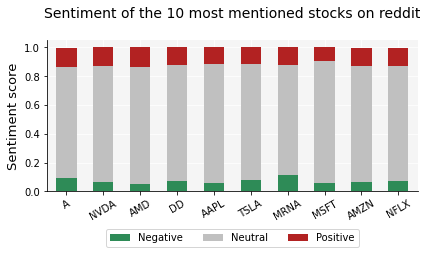

In [6]:
rd.Dataviz_Sentiment()

Whereas the absolute values of positive and negative sentiment are not very meaningful, the compound score is our measure of interest. As you can see from the project report, the compound score serves as a standardized value for categorizing sentiment scores in a very comfortable way. It sums up the valence scores of each word in the lexicon and normalizes to be beween -1 and 1 (most negative to most positive). The RedditData object now provides us with information about the final classification of each comment (and every stock as a whole).

In [7]:
rd.reportdf

,Stock,Sentiment,Comment
0,A,neutral,"question to all, so when the shrek cock deflat..."
1,A,positive,body has been running up all week with little ...
2,A,positive,i always felt so bad for toby when i was young...
3,A,neutral,"didn't care yesterday, don't give a shit today..."
4,A,neutral,"didn't care yesterday, don't give a shit today..."
...,...,...,...
1838,NFLX,positive,they have a whole host of problems... they la...
1839,NFLX,positive,they have a whole host of problems... they la...
1840,NFLX,positive,"i haven’t bought nflx yet, but i want to once ..."
1841,NFLX,neutral,wait for drops after earnings. include nflx as...


### 2. RedditPredict: Predict stock price development using random forest & creating an early signal model

RedditPredict uses random forest machine learning to predict the stock price development. As this is a simple classification task, either -1 (stock price will decrease in five days) or +1 (stock price will increase in five days), random forest classification is used!


Random forests provide an improvement over simple classification trees and bagged trees by way of a small tweak that decorrelates the trees. Random forest models calculate $\hat{f}^1(x), \hat{f}^2(x), ..., \hat{f}^B(x)$ trees using $B$ separate training sets and average them in order to obtain one single low-variance random forest model given by:

$\hat{f}_{avg}(x) = \frac{1}{B} \sum_{b = 1}^{B} \hat{f}^b(x)$ 

Futher information regarding the reasons for random forests as classification method can be seen in the project report!

In [8]:
class RedditPredict:

    def __init__(self, startdate = "2020-01-01"):
        start = startdate
        end = str(date.today())
        assets = rd.top_picks           # List of top 10 Reddits
        self.assets_stockdata = list()

        ### Downloading stock market data from all top picks!
        for asset in assets:
            exec("self.{} = yf.download(asset, start = start, end = end, progress = False)".format(asset))
            self.assets_stockdata.append(getattr(self, asset))

        print(f"Downloaded data for {len(rd.top_picks)} stocks from yahoo finance from {start} to {end}, "
              f"resulting in {self.assets_stockdata[0].shape[0]} samples each.")


    def ModelPrep(self):
        """ Feature creation via TA-Lib library (https://github.com/mrjbq7/ta-lib):

            Key feature creating based on TA library. From homepage:
                TA-Lib is widely used by trading software developers requiring to perform technical analysis of 
                financial market data.

                - Includes 150+ indicators such as ADX, MACD, RSI, Stochastic, Bollinger Bands, etc.
                - Candlestick pattern recognition
                - Open-source API for C/C++, Java, Perl, Python and 100% Managed .NET
            (quoted from https://github.com/mrjbq7/ta-lib)
            """

        for asset in self.assets_stockdata:
            ### Creating features using technical analysis library
            asset["RSI"] = ta.RSI(asset["Close"], timeperiod = 14)  # Relative Strength Index
            asset["WILLR"] = ta.WILLR(asset["High"],
                                      asset["Low"],
                                      asset["Close"],
                                      timeperiod = 14)              # Williams %R
            asset["ROC"] = ta.ROC(asset["Close"], timeperiod = 10)  # Rate of Change
            asset["OBV"] = ta.OBV(asset["Close"], asset["Volume"])  # On-balance volume
            asset["MACD"], asset["MACD_SIGNAL"], asset["MACD_HIST"] = ta.MACD(asset["Close"], fastperiod = 12,
                                                                              slowperiod = 26,
                                                                              signalperiod = 9)

            ### Creating label
            # See if the close price 5 days after today is higher or lower
            asset["Development"] = np.where(asset["Close"].shift(-5) > asset["Close"], 1, -1)

            """
            Development column:
            Development == 1: Stock price (close price) will increase in 5 days
            Development == -1: Stock price (close price) will decrease in 5 days 
            """


        ### Creating large dataset for later test-/train split
        # Remember: rd.top_picks == Top 10 most mentioned S&P 500 Stocks on Reddit
        # --> In the following: Storing df nr. 4-10 within one large dataframe
        self.large_stockdata = pd.concat(self.assets_stockdata[3:], keys = rd.top_picks[3:])

        ### Drop NaN
        self.large_stockdata.dropna(inplace = True)
        print(f"{self.large_stockdata.shape[0]} samples available for test-/train split.")


    def TrainTestSplit(self, trainsize = 0.7, info = True):
        # Creating feature matrix & label vector
        X = self.large_stockdata[["RSI", "ROC", "OBV", "WILLR", "MACD", "MACD_SIGNAL", "MACD_HIST",
                                  "Close", "High", "Volume", "Low", "Open"]]
        y = self.large_stockdata.Development

        # Test-/Train split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state = 0, train_size = trainsize)

        if info == True:
            print("--- Trainingdata:")
            print(f"X_train:  Samples -  {self.X_train.shape[0]}; Features - {self.X_train.shape[1]}")
            print(f"y_train:  Samples -  {self.y_train.shape[0]}\n")
            print("--- Testdata:")
            print(f"X_test:   Samples -  {self.X_test.shape[0]}; Features - {self.X_test.shape[1]}")
            print(f"y_test:   Samples -  {self.y_test.shape[0]}")


    def CrossVal(self):
        ### Set of hyperparameter
        n_estimators = [10, 100, 500, 750, 1000]
        max_features = ["auto", "sqrt", "log2", None]
        max_depth = [50, 100, 200, 500, 1000, 1500, None]
        min_samples_split = [2, 5,10,50, 200]
        min_samples_leaf = [1, 10,50,100, 200]

        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf}

        ### Initialize 10-fold CV
        rf = RandomForestClassifier()
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                       n_iter = 100, cv = 10, verbose = 2, random_state = 42,
                                       n_jobs = -1)
        rf_random.fit(self.X_train, self.y_train)

        ### Print CV output
        print(rf_random.best_params_)

        
    def FitPerfectHyperparam(self, best_n_estimators = 1000, crit = "gini", best_min_samples_split = 100, 
                             best_min_samples_leaf = 100, best_max_features = "sqrt", best_max_depth = 100, 
                             confusion = True):
        
        ### Setup random forest model
        self.forest = RandomForestClassifier(n_estimators=best_n_estimators,
                                        oob_score=True,
                                        criterion=crit,
                                        random_state=0,
                                        min_samples_split = best_min_samples_split,
                                        min_samples_leaf = best_min_samples_leaf,
                                        max_features = best_max_features,
                                        max_depth = best_max_depth)

        ### Training the model (i.e. fitting)
        self.forest.fit(self.X_train, self.y_train)

        ### Predict validation set & return accuracy
        y_pred = self.forest.predict(self.X_test)

        ## Output godness of fit
        print("Correct predictions:       {0:3.1%}".format(1 - ((self.y_test != y_pred).sum() / self.y_test.shape[0])))
        print("Missclassified samples:    {0}/{1}".format((self.y_test != y_pred).sum(), self.y_test.shape[0]))

        ### Confusion matrix
        if confusion == True:
            cm = confusion_matrix(self.y_test, y_pred)

            plt.figure(figsize=(10, 8))
            sn.heatmap(cm, annot=True,
                       linewidths =.5,
                       annot_kws={"size":17},
                       fmt = "g")
            plt.title("Confusion matrix (testset)\n", fontsize = 23)
            plt.xlabel("Predicted", fontsize = 15)
            plt.ylabel("Truth", fontsize = 15)
            plt.show()


    def Predict(self):
        ### Predict label for top 3 most discussed Reddit stocks
        for stock in self.assets_stockdata[:3]:
            stock.dropna(inplace = True)
            del stock["Development"]
            stock["Prediction"] = self.forest.predict(stock[["RSI", "ROC", "OBV", "WILLR", "MACD", "MACD_SIGNAL", "MACD_HIST",
                                  "Close", "High", "Volume", "Low", "Open"]])


    def EarlySignal(self, daysconstant = 5):
        BuyPr, SellPr = list(), list()   # Close prices for buying and selling
        indicator = -1                   # Indicating if we are currently within a buy or sell signal
        count = 0                        # Counting the days for accepting new signal
        n = daysconstant                 # After how many days can we change signal

        """Reminder: This class predicts the stock price movement in 5 days. Within these five 
        days, there should be no change in trading signals. Therefore we define daysconstant = 5!
        Every 5 timestamps the signal can be changed.
        
        "indicator" indicates whether we change our signal or not. If we receive a buy signal and 5 days later there
        is another prediction "1", "indicator" stays at 1, so "NaN" is added to the df and we hold our portfolio until 
        the next sell signal.
        """

        ### Creating buy/sell signals for top 3 stocks
        for asset in self.assets_stockdata[:3]:
            for i in range(len(asset)):

                ## Buy-signal
                if asset["Prediction"][i] == 1 and count == 0:
                    if indicator != 1:
                        BuyPr.append(asset["Close"][i])
                        SellPr.append(np.nan)
                        indicator = 1
                    else:
                        BuyPr.append(np.nan)
                        SellPr.append(np.nan)

                ## Sell-signal
                elif asset["Prediction"][i] == -1 and count == 0:
                    if indicator != 0:
                        BuyPr.append(np.nan)
                        SellPr.append(asset["Close"][i])
                        indicator = 0
                    else:
                        BuyPr.append(np.nan)
                        SellPr.append(np.nan)

                ## Extend current signal
                else:
                    BuyPr.append(np.nan)
                    SellPr.append(np.nan)


                ## Only change signal after 5 days
                count += 1
                if count == n:
                    count = 0


            ### Add early signals to the stocks dataframe
            asset["Buy"] = BuyPr
            asset["Sell"] = SellPr

            ### Clear for next iteration
            BuyPr, SellPr = list(), list()



    def VizualEarlySignal(self, stocknr = 1, perf = True):
        
        ### Vizualisation of the predicted trading signals
        plt.figure(figsize = (16,8))
        ax = plt.axes()
        ax.set_facecolor('whitesmoke')
        plt.grid(color='w', linestyle='solid')

        plt.scatter(self.assets_stockdata[stocknr].index, self.assets_stockdata[stocknr]["Buy"],
                    color = "green",
                    label = "Buy",
                    marker = "^",
                    alpha = 1,
                    s = 65)
        plt.scatter(self.assets_stockdata[stocknr].index, self.assets_stockdata[stocknr]["Sell"],
                    color = "red",
                    label = "Sell",
                    marker = "v",
                    alpha = 1,
                    s = 65)
        plt.plot(self.assets_stockdata[stocknr].index, self.assets_stockdata[stocknr]["Close"],
                 alpha = 0.5,
                 linewidth = 1.5)

        plt.title(f"{rd.top_picks[stocknr]}: Stock price development incl. early signals from random forest algorithm\n", fontsize = 20)
        plt.xlabel("Timeperiod", fontsize = 18)
        plt.ylabel("Stock price", fontsize = 18)
        plt.show()


        ## Vizualisation of hypothetical investment in the amount of EUR100.0k
        if perf == True:
            
            # Set warnings off since our hypothetical investment requires to set the first sell signal 
            # to NaN if it takes place before the first buy signal
            import warnings
            warnings.filterwarnings('ignore')
            
            portfolio = [100000]
            stocks_count = 0

            """We want to have a look at a hypothetical investment in the amount of EUR100k.
            For this analysis it is essential, that we buy at the first signal (which of course should be a buy rather
            than a sell signal). 
            Therefore, we have to get sure that the first buy date takes place before the first sell date.
            Otherwise this hypothethical investment wouldnt make much sense if we sell the portfolio before we buyed it. 
            If the first sell date comes before the first buy date, we will temporarily overwrite the first 
            sell signal with NaN and hold our initial cash until the first buy signal."""


            ### Get sure, that we will first buy
            FirstSellDate = self.assets_stockdata[stocknr].Sell.first_valid_index()
            FirstBuyDate = self.assets_stockdata[stocknr].Buy.first_valid_index()

            FirstSellLoc = self.assets_stockdata[stocknr].Sell.index.get_loc(FirstSellDate)
            FirstBuyLoc = self.assets_stockdata[stocknr].Buy.index.get_loc(FirstBuyDate)

            FirstSellValue = self.assets_stockdata[stocknr].Sell[FirstSellLoc]

            if FirstSellLoc < FirstBuyLoc:
                self.assets_stockdata[stocknr].Sell[FirstSellLoc] = math.nan


            for i in range(len(self.assets_stockdata[stocknr])):

                ## Buy action
                # if self.assets_stockdata[stocknr]["Buy"][i] != math.nan
                if math.isnan(self.assets_stockdata[stocknr]["Buy"][i]) == False: # Wenn an dem i kein nan ist, dann kaufe aktien
                    stocks_count = portfolio[i]/self.assets_stockdata[stocknr]["Close"][i]
                    portfolio.append(stocks_count * self.assets_stockdata[stocknr]["Close"][i])

                ## Sell action
                elif math.isnan(self.assets_stockdata[stocknr]["Sell"][i]) == False:
                    liquidity = stocks_count * self.assets_stockdata[stocknr]["Close"][i]
                    portfolio.append(liquidity)

                else:
                    portfolio.append(portfolio[i])


            #if self.assets_stockdata[stocknr].Sell[FirstSellLoc] == math.nan:
            #    self.assets_stockdata[stocknr].Sell[FirstSellLoc] = FirstSellValue


            plt.figure(figsize = (16,8))
            ax = plt.axes()
            ax.set_facecolor('whitesmoke')
            plt.grid(color='w', linestyle='solid')

            plt.plot(portfolio)
            plt.title(f"{rd.top_picks[stocknr]}: Performance of a hypothetical investment in the amount of "
                      f"USD {portfolio[0]} \n following each trading signal\n", fontsize = 20)
            plt.xlabel("Timeperiod in days", fontsize = 18)
            plt.ylabel("Portfolio value (Cash)", fontsize = 18)
            plt.show()

#### See the results:

**1. Step:** Downloading the relevant stock market data for all "top n stocks" from the previous shown RedditData class. You can specify for which time period the stock market data should be scraped within the object argument. Obviously, the further back the start date, the larger the data set for the subsequent test/training split and model fitting. Object instances store each stock market information as an attribute.

In [9]:
rpred = RedditPredict(startdate = "2020-01-01")

Downloaded data for 10 stocks from yahoo finance from 2020-01-01 to 2021-07-23, resulting in 393 samples each.


--> Each of the 10 shares can be called as an attribute of the RedditPredict object instances.

In [10]:
rpred.NVDA

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,57.724998,58.919998,57.532501,58.825001,58.694374,23100400
2020-01-02,59.687500,59.977501,59.180000,59.977501,59.844322,23753600
2020-01-03,58.775002,59.457500,58.525002,59.017502,58.886452,20538400
2020-01-06,58.080002,59.317501,57.817501,59.264999,59.133400,26263600
2020-01-07,59.549999,60.442501,59.097500,59.982498,59.849308,31485600
...,...,...,...,...,...,...
2021-07-16,190.304993,191.570007,180.729996,181.610001,181.610001,68822400
2021-07-19,179.152496,190.419998,178.654999,187.797501,187.797501,74906000
2021-07-20,187.300003,188.380005,181.639999,186.119995,186.119995,43424500


**2. Step:** Prepairing the model for the machine learning algorithm. This step includes creating an appropiate feature set. Therefore, I used the TA-Lib library (see project report). Furthermore, labels were created ("Development" column) which indicate: 
- increasing (Development = $1$) or 
- decreasing (Development = $-1$) 

stock prices in 5 days. Those additional features and label will be computed for every sample within all object attributes (i.e. stocks) automatically. Additionally, the stock market data from the 4<sup>th</sup> to 10<sup>th</sup> most mentioned stocks on Reddit were combined together and serve as a training/test set in the next step. Of course, NaN values were removed from the combined dataset.

In [11]:
rpred.ModelPrep()

2520 samples available for test-/train split.


In [12]:
rpred.NVDA.head(100) # Stock market data including additional features and development label

,Open,High,Low,Close,Adj Close,Volume,RSI,WILLR,ROC,OBV,MACD,MACD_SIGNAL,MACD_HIST,Development
Date,,,,,,,,,,,,,,
2019-12-31,57.724998,58.919998,57.532501,58.825001,58.694374,23100400,NaN,NaN,NaN,23100400.0,NaN,NaN,NaN,1
2020-01-02,59.687500,59.977501,59.180000,59.977501,59.844322,23753600,NaN,NaN,NaN,46854000.0,NaN,NaN,NaN,1
2020-01-03,58.775002,59.457500,58.525002,59.017502,58.886452,20538400,NaN,NaN,NaN,26315600.0,NaN,NaN,NaN,1
2020-01-06,58.080002,59.317501,57.817501,59.264999,59.133400,26263600,NaN,NaN,NaN,52579200.0,NaN,NaN,NaN,1
2020-01-07,59.549999,60.442501,59.097500,59.982498,59.849308,31485600,NaN,NaN,NaN,84064800.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,87.605003,89.165001,86.805000,87.502502,87.360428,77446000,71.375146,-8.770764,20.158605,430480800.0,4.150131,3.235348,0.914783,-1
2020-05-19,87.902496,90.875000,87.627502,88.055000,87.912033,71732000,71.899232,-13.646260,19.908767,502212800.0,4.547869,3.497852,1.050017,-1
2020-05-20,89.910004,90.430000,88.887497,89.699997,89.554344,58753600,73.457428,-5.685957,20.487584,560966400.0,4.938885,3.786059,1.152826,-1


In [13]:
# Combined all datasets
# Stock market data from top 4-10 stocks from RedditData available for test-/train split!
# NaN values were already removed within this data set
rpred.large_stockdata

Open        High         Low       Close   Adj Close  \
     Date                                                                     
DD   2020-02-19   53.650002   53.939999   53.290001   53.500000   51.897472   
     2020-02-20   53.250000   53.650002   52.259998   52.549999   50.975929   
     2020-02-21   52.220001   52.619999   52.020000   52.430000   50.859524   
     2020-02-24   50.599998   50.990002   49.599998   50.450001   48.938835   
     2020-02-25   50.500000   50.500000   47.020000   47.470001   46.048096   
...                     ...         ...         ...         ...         ...   
NFLX 2021-07-16  541.809998  544.059998  527.049988  530.309998  530.309998   
     2021-07-19  526.049988  534.909973  522.239990  532.280029  532.280029   
     2021-07-20  526.070007  536.640015  520.299988  531.049988  531.049988   
     2021-07-21  526.130005  530.989990  505.609985  513.630005  513.630005   
     2021-07-22  510.209991  513.679993  507.000000  511.769989  511.769989   

                   Volume        RSI      WILLR       ROC         OBV  \
     Date                                                               
DD   2020-02-19   6395500  36.446624 -40.133049  1.518025 -43137200.0   
     2020-02-20   4971900  33.346614 -52.702712 -2.829147 -48109100.0   
     2020-02-21   4033500  32.965198 -55.945926 -2.564581 -52142600.0   
     2020-02-24   7087800  27.396909 -82.653020 -3.996191 -59230400.0   
     2020-02-25  10657600  21.508350 -93.983947 -8.323673 -69888000.0   
...                   ...        ...        ...       ...         ...   
NFLX 2021-07-16   3436700  54.006904 -82.565181 -0.605387  27534600.0   
     2021-07-19   3885800  55.265379 -71.557953 -0.318355  31420400.0   
     2021-07-20   6806500  54.266947 -71.133183 -1.955178  24613900.0   
     2021-07-21  11894200  42.544430 -84.556093 -4.166359  12719700.0   
     2021-07-22   4326400  41.513270 -88.137869 -3.577892   8393300.0   

                     MACD  MACD_SIGNAL  MACD_HIST  Development  
     Date                                                       
DD   2020-02-19 -2.364776    -2.851674   0.486897           -1  
     2020-02-20 -2.293143    -2.739967   0.446825           -1  
     2020-02-21 -2.220460    -2.636066   0.415606           -1  
     2020-02-24 -2.296158    -2.568084   0.271926           -1  
     2020-02-25 -2.567020    -2.567872   0.000851           -1  
...                   ...          ...        ...          ...  
NFLX 2021-07-16  9.334359     9.370516  -0.036157           -1  
     2021-07-19  8.463776     9.189168  -0.725391           -1  
     2021-07-20  7.587120     8.868758  -1.281638           -1  
     2021-07-21  5.424190     8.179844  -2.755655           -1  
     2021-07-22  3.519395     7.247754  -3.728360           -1  

[2520 rows x 14 columns]

**3. Step:** Splitting the samples in trainings and testdata. The trainsize can be adjusted manually. One can specify, if information about the split should be printed or not.

In [14]:
rpred.TrainTestSplit(trainsize = 0.8, info = True)

--- Trainingdata:
X_train:  Samples -  2016; Features - 12
y_train:  Samples -  2016

--- Testdata:
X_test:   Samples -  504; Features - 12
y_test:   Samples -  504


**4. Step:** Using cross validation to optimize the hyperparameters for the random forest model. This method can be applied to instances of RedditPredict objects. It tests different sets of hyperparameter and evaluates over 1,000 different models in order to find the set of hyperparameter resulting in the lowest cross validation error. The different sets of parameter to be tested
were set within the class method.

As this is a simple binary classification task, we will use the set of hyperparameter for which the classification error is lowest in the next step: <br>

$CV_{(n)} = \frac{1}{n} \sum_{i = 1}^{n} I(y_i \neq \hat{y}_i)$

In [15]:
rpred.CrossVal()

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 500}


**4. Step:** Fitting the model using the hyperparameters computed from the cross validation (third step). We can set different hyperparameter as arguments within the FitPerfectHyperparam() method of RedditPredict objects (instances). Of course, one would prefer to set the hyperparameter to those from the cross validation output in step 4.

If 'confusion = True', a confusion matrix, representing the results from using the predictive model to predict the development in the testset, will be printed. 

Correct predictions:       80.4%
Missclassified samples:    99/504


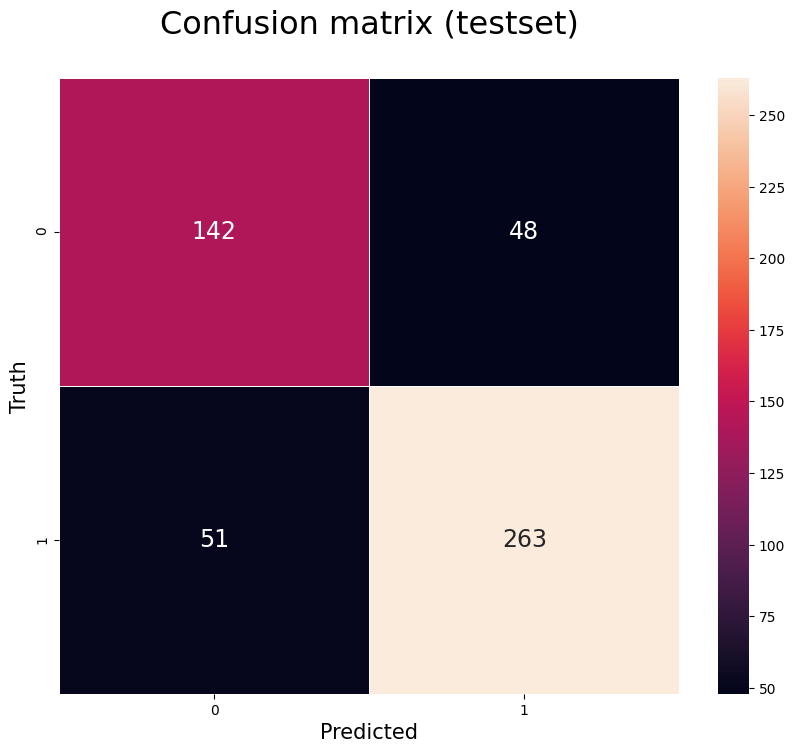

In [16]:
rpred.FitPerfectHyperparam(best_n_estimators = 1000,
                           best_min_samples_split = 2, 
                           best_min_samples_leaf = 1,
                           best_max_features="log2",
                           best_max_depth=500,
                           confusion = True)

**5. Step:** Predicting the label for the top 3 most discussed Reddit stocks (unseen data) using the predictive model from step 4. The predicted values will be stored in the corresponding instance attribute.

In [17]:
rpred.Predict()

In [18]:
rpred.NVDA

,Open,High,Low,Close,Adj Close,Volume,RSI,WILLR,ROC,OBV,MACD,MACD_SIGNAL,MACD_HIST,Prediction
Date,,,,,,,,,,,,,,
2020-02-19,75.372498,78.852501,75.372498,78.675003,78.500298,69433200,83.668825,-0.880227,27.341887,5.453872e+08,3.366823,1.557556,1.809267,1
2020-02-20,78.192497,79.080002,74.087502,77.175003,77.003632,81005200,77.941079,-9.341663,23.105766,4.643820e+08,3.783912,2.002827,1.781085,1
2020-02-21,76.047501,76.300003,72.665001,73.517502,73.354263,76818000,66.065085,-27.513289,15.661753,3.875640e+08,3.775802,2.357422,1.418380,-1
2020-02-24,67.547501,70.467499,67.000000,68.320000,68.168289,85691600,53.572779,-59.529747,8.621170,3.018724e+08,3.311804,2.548299,0.763506,1
2020-02-25,69.074997,69.697502,64.489998,65.512497,65.367020,105549600,48.263895,-78.754922,-0.349855,1.963228e+08,2.686571,2.575953,0.110618,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,190.304993,191.570007,180.729996,181.610001,181.610001,68822400,41.390787,-96.859369,-10.147435,2.370893e+09,5.107028,8.234876,-3.127848,1
2021-07-19,179.152496,190.419998,178.654999,187.797501,187.797501,74906000,48.122162,-69.621195,-8.333331,2.445799e+09,4.120674,7.412035,-3.291361,1
2021-07-20,187.300003,188.380005,181.639999,186.119995,186.119995,43424500,46.560841,-75.195228,-10.080443,2.402374e+09,3.167113,6.563051,-3.395938,1


**6. Step:** Creating an early signal model based on the predictions from step 5. Executing this method, the object will iterate through all predictions in order to find buy and sell signals every 5 days. The class iterates through every prediction and checks whether there is a change in prediction after every five days. If we receive a buy signal, we will save the signal with the corresponding close price. If there is another buy signal after 5 days, NaN is added and we don't change our trading recommendation until the next sell signal (i.e. $-1$ prediction).

All the trading signals are stored within the instance attributes as well!

In [19]:
rpred.EarlySignal(daysconstant = 5)

In [20]:
rpred.NVDA

,Open,High,Low,Close,Adj Close,Volume,RSI,WILLR,ROC,OBV,MACD,MACD_SIGNAL,MACD_HIST,Prediction,Buy,Sell
Date,,,,,,,,,,,,,,,,
2020-02-19,75.372498,78.852501,75.372498,78.675003,78.500298,69433200,83.668825,-0.880227,27.341887,5.453872e+08,3.366823,1.557556,1.809267,1,NaN,NaN
2020-02-20,78.192497,79.080002,74.087502,77.175003,77.003632,81005200,77.941079,-9.341663,23.105766,4.643820e+08,3.783912,2.002827,1.781085,1,NaN,NaN
2020-02-21,76.047501,76.300003,72.665001,73.517502,73.354263,76818000,66.065085,-27.513289,15.661753,3.875640e+08,3.775802,2.357422,1.418380,-1,NaN,NaN
2020-02-24,67.547501,70.467499,67.000000,68.320000,68.168289,85691600,53.572779,-59.529747,8.621170,3.018724e+08,3.311804,2.548299,0.763506,1,NaN,NaN
2020-02-25,69.074997,69.697502,64.489998,65.512497,65.367020,105549600,48.263895,-78.754922,-0.349855,1.963228e+08,2.686571,2.575953,0.110618,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,190.304993,191.570007,180.729996,181.610001,181.610001,68822400,41.390787,-96.859369,-10.147435,2.370893e+09,5.107028,8.234876,-3.127848,1,NaN,NaN
2021-07-19,179.152496,190.419998,178.654999,187.797501,187.797501,74906000,48.122162,-69.621195,-8.333331,2.445799e+09,4.120674,7.412035,-3.291361,1,NaN,NaN
2021-07-20,187.300003,188.380005,181.639999,186.119995,186.119995,43424500,46.560841,-75.195228,-10.080443,2.402374e+09,3.167113,6.563051,-3.395938,1,NaN,NaN


**7. Step:** To vizualisize the trading signals we can apply the VizualEarlySignal method to the RedditPredict objects. You can determine for which of the top three stocks the early signal model should be plotted (allowed arguments are: 0-2, for the top 3 stocks).

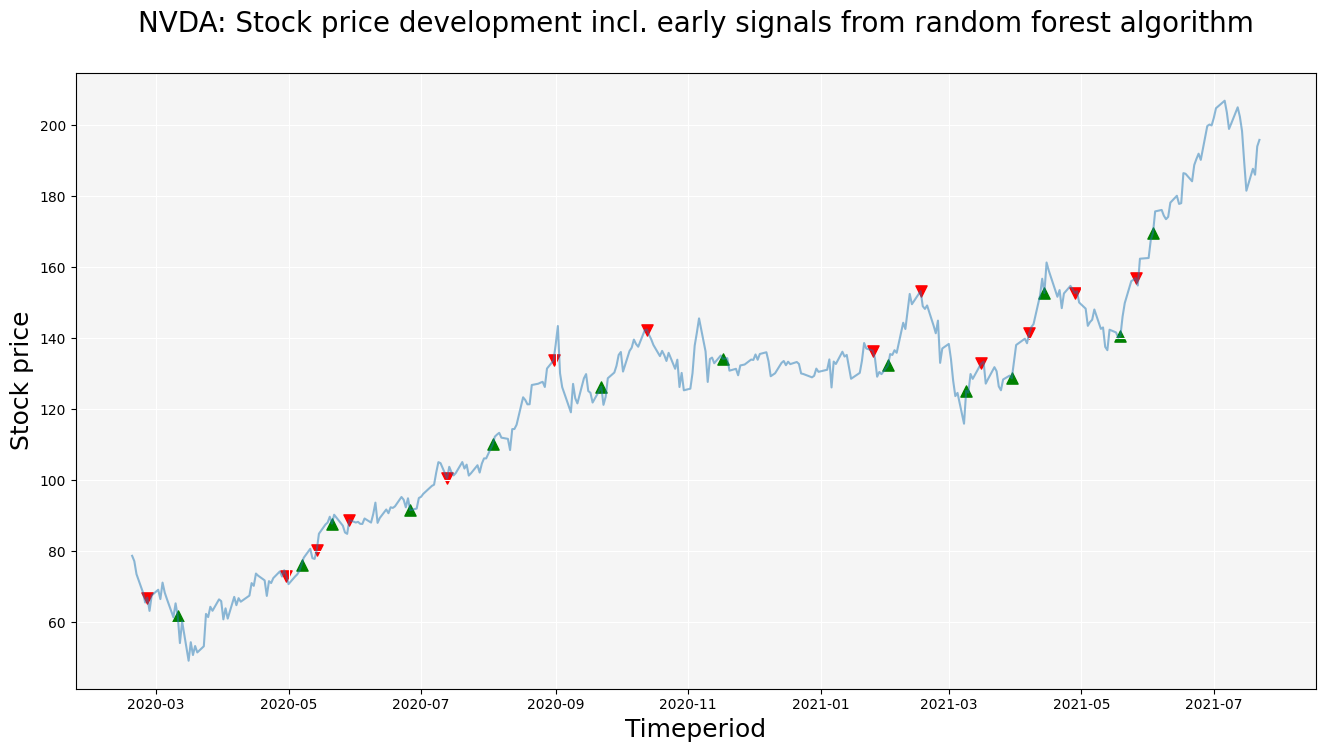

In [21]:
rpred.VizualEarlySignal(1, perf = False)

It is also possible to set 'perf = True' as an argument in order to receive a plot which shows the development of a hypothetical investment! The plot shows the portfolio value of the hypotetical investment if one follows all trading signals relating from the random forest prediction.

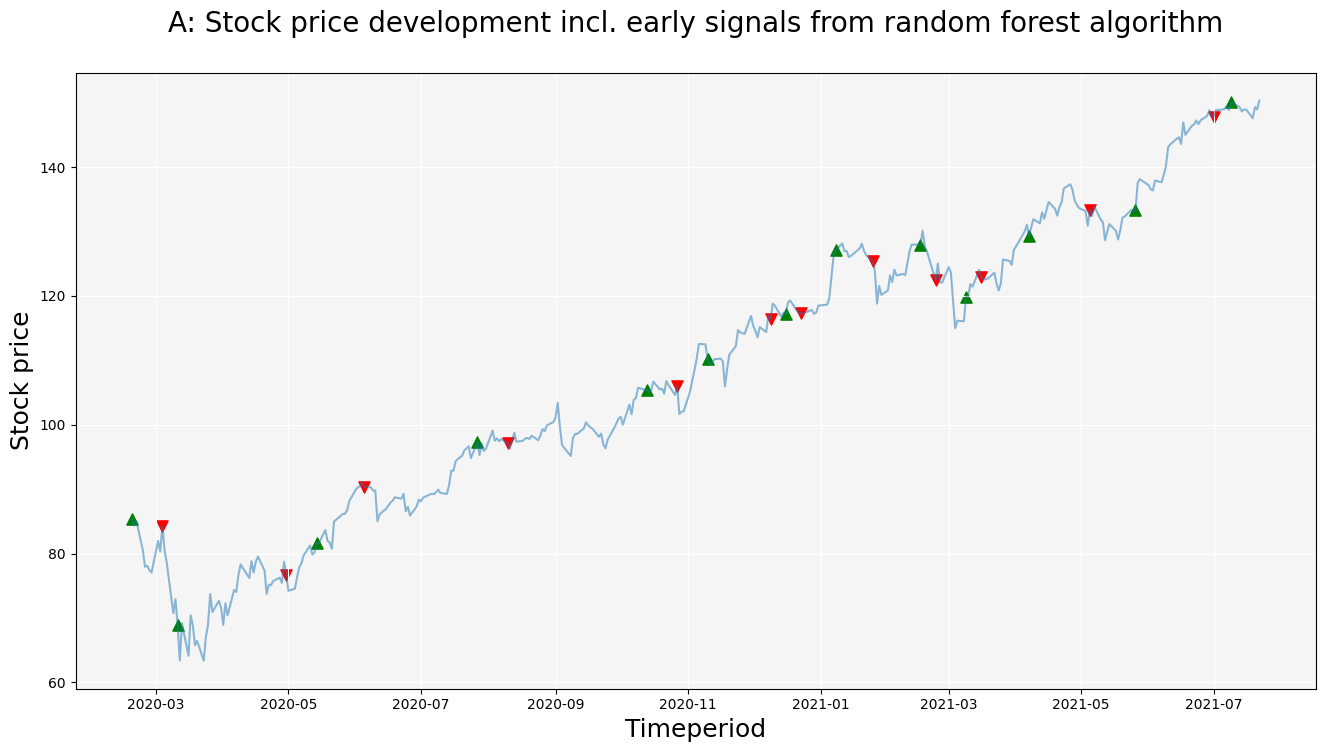

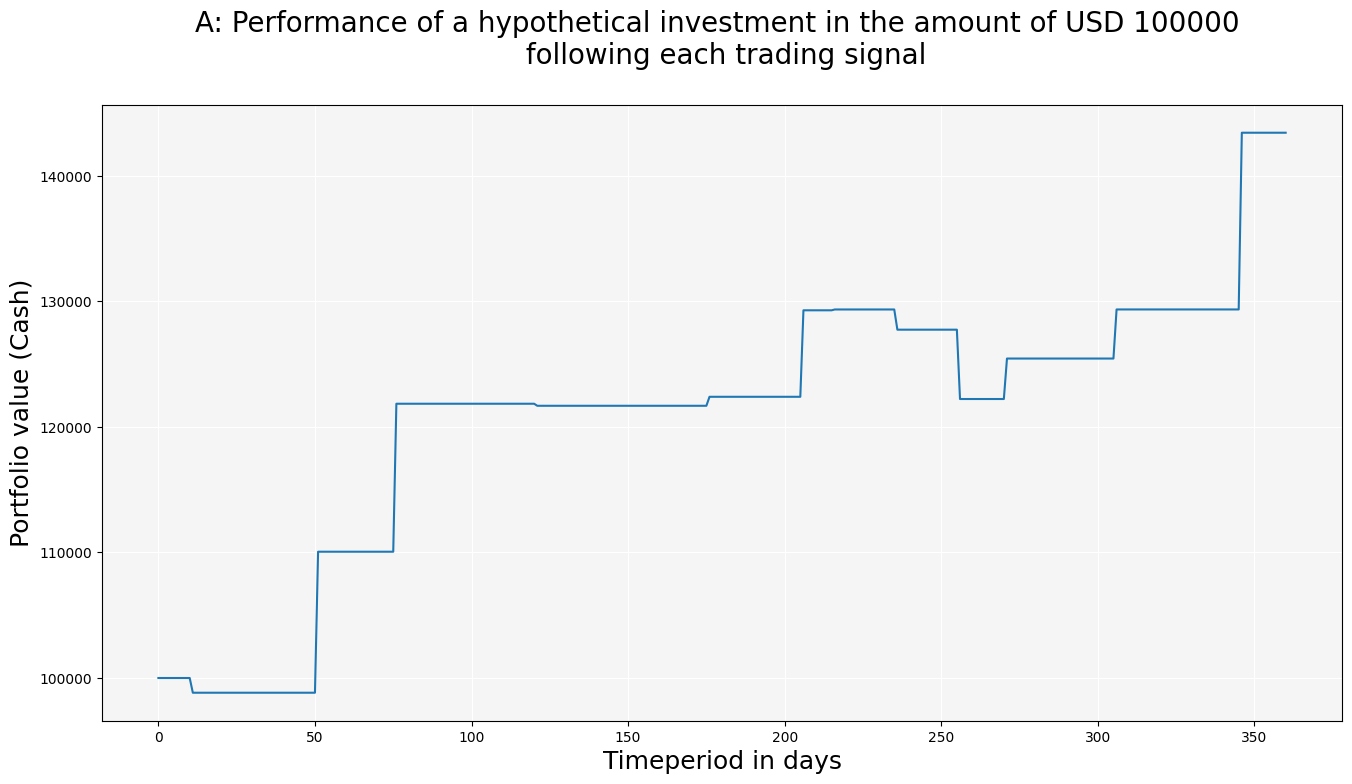

In [22]:
rpred.VizualEarlySignal(0, perf = True)

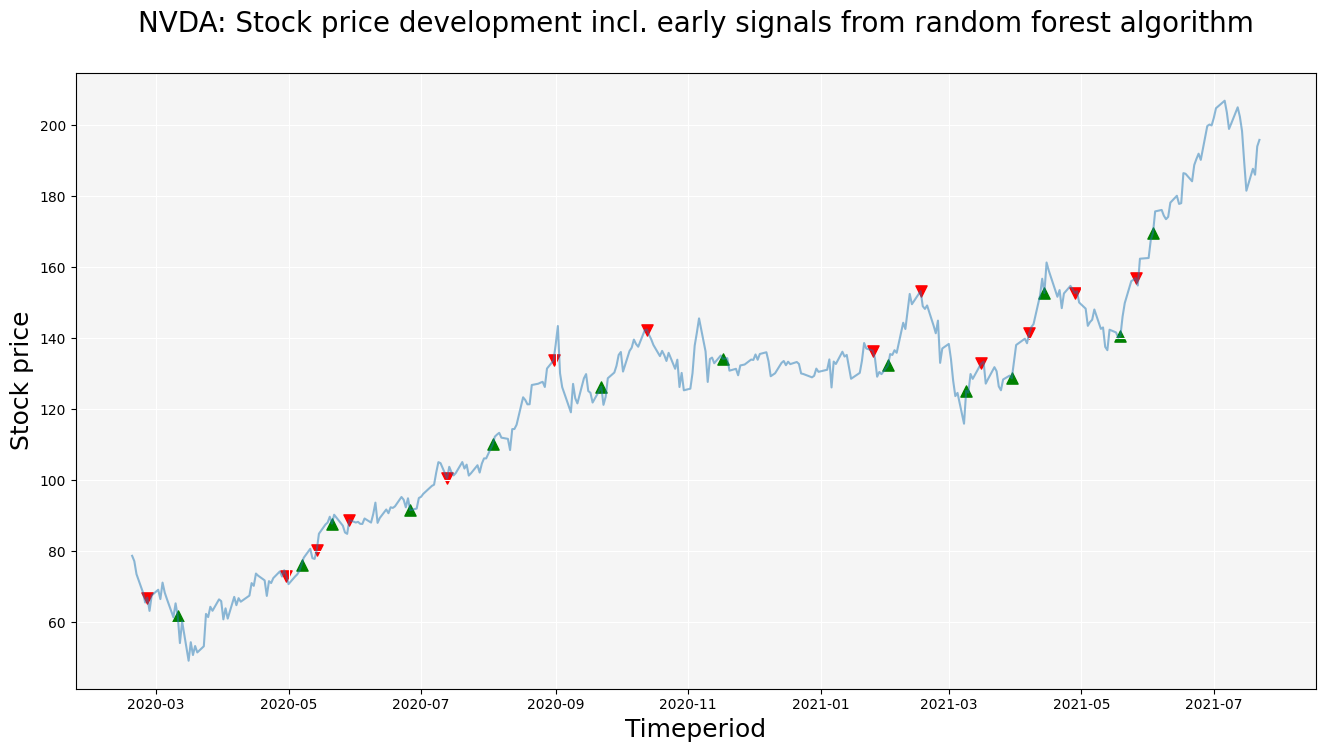

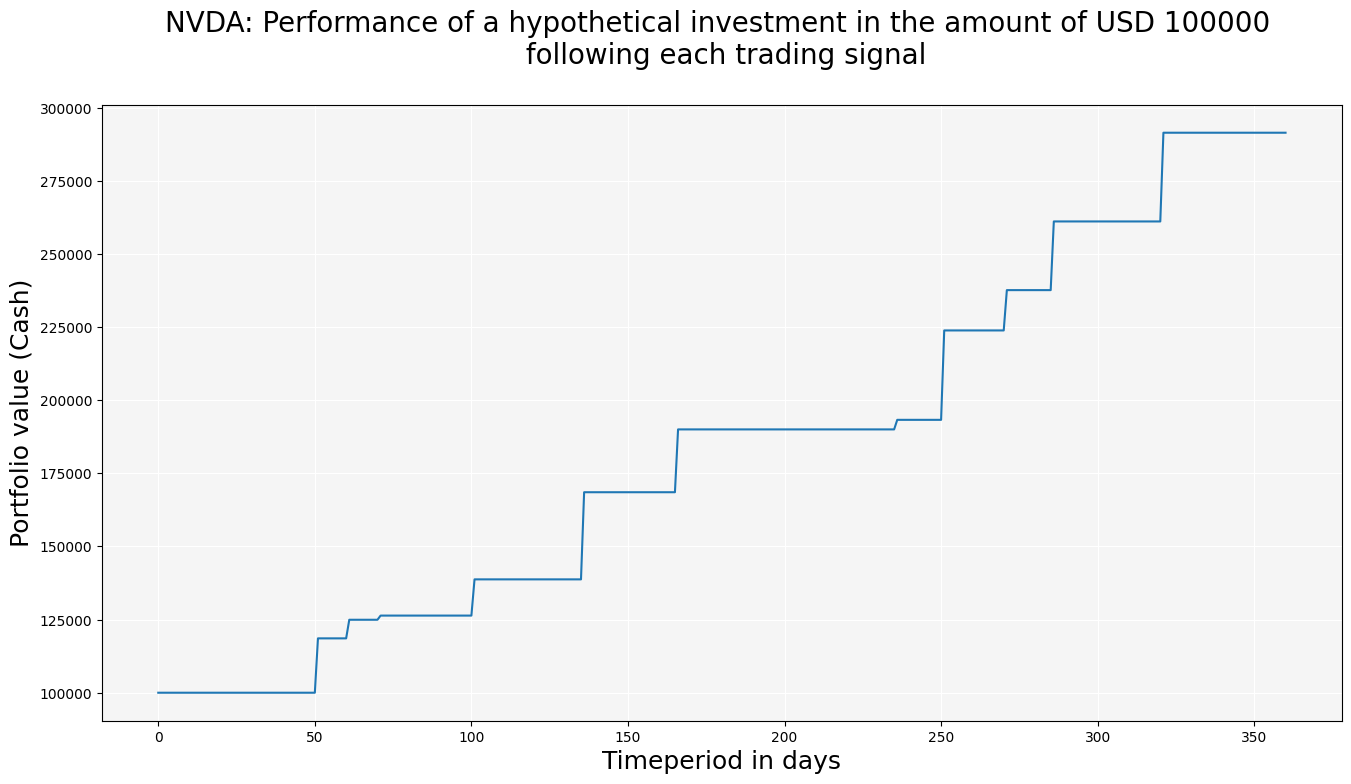

In [23]:
rpred.VizualEarlySignal(1, perf = True)

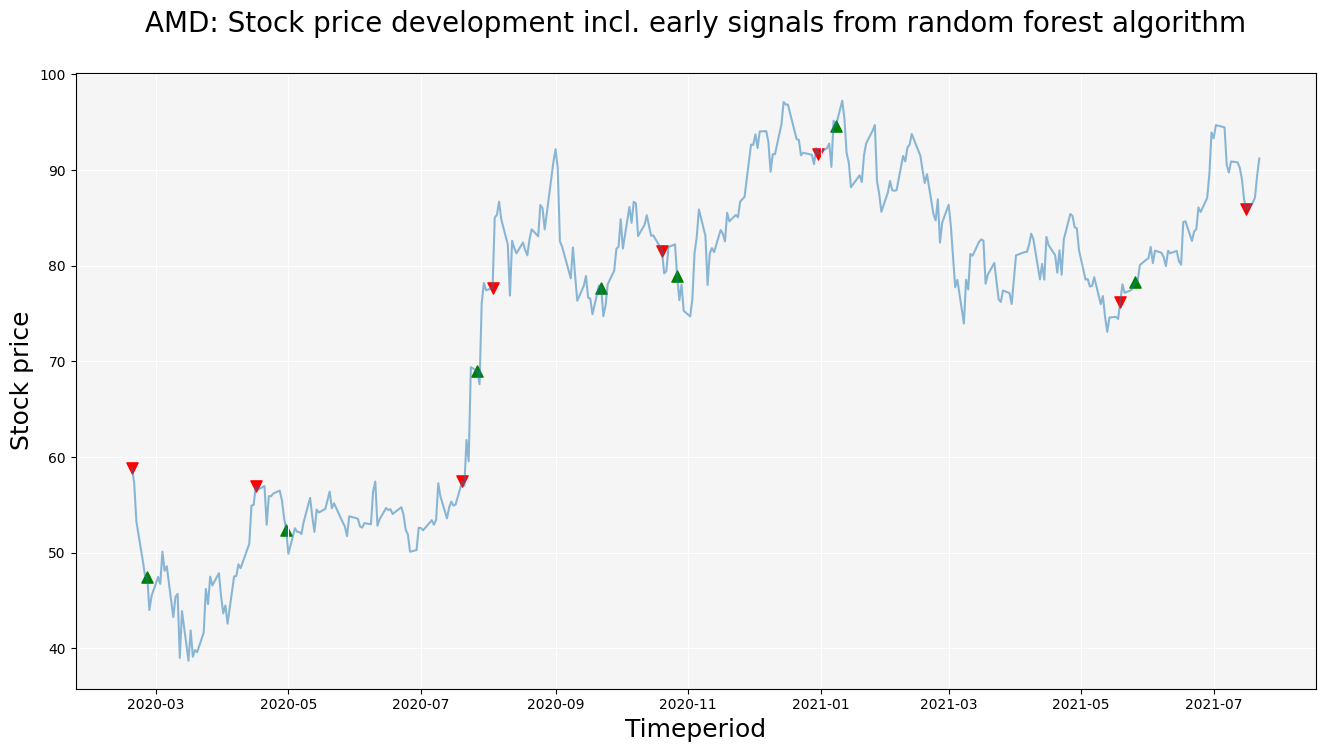

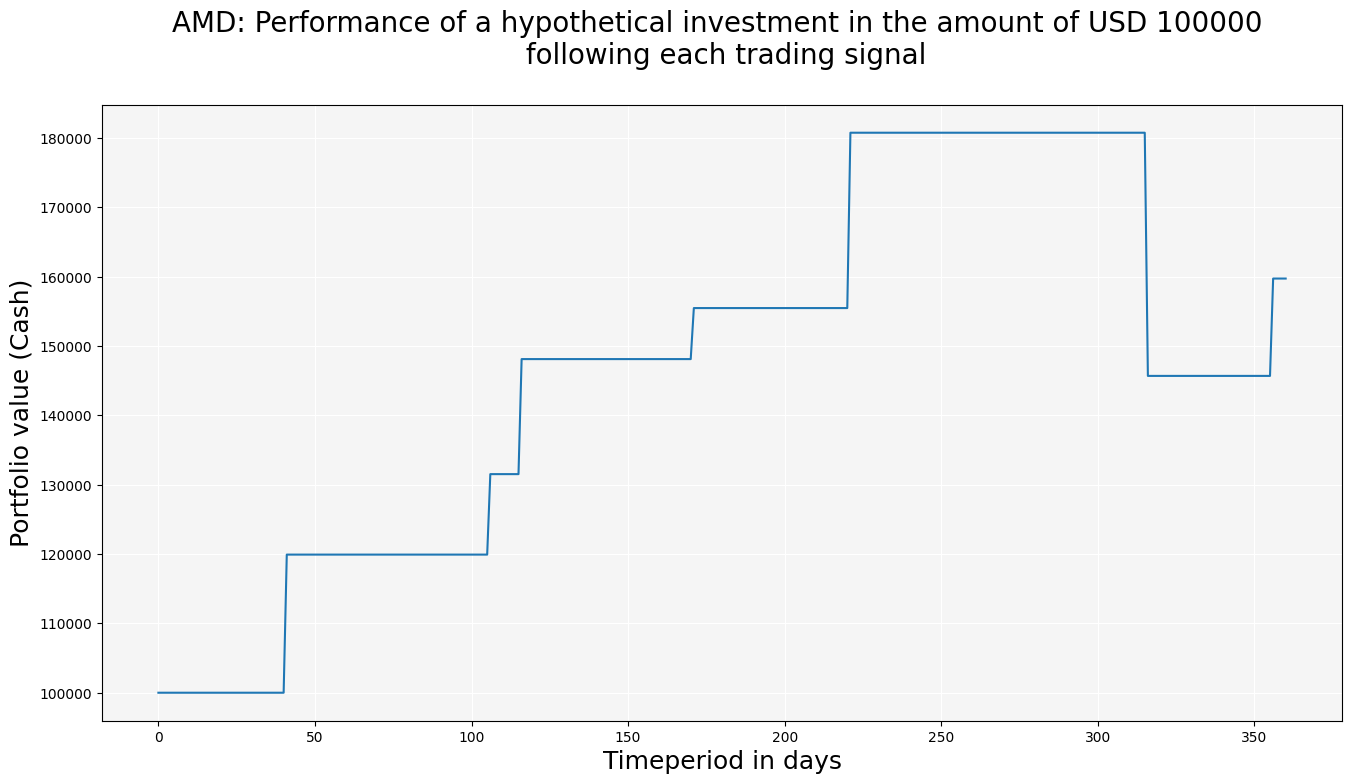

In [24]:
rpred.VizualEarlySignal(2, perf = True)